<a href="https://colab.research.google.com/github/ak9250/stylegan/blob/master/stylegan_kogan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!git clone https://github.com/genekogan/stylegan.git

Cloning into 'stylegan'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 74 (delta 25), reused 68 (delta 19), pack-reused 0
Unpacking objects: 100% (74/74), done.


In [2]:
!ls

sample_data  stylegan


In [5]:
cd stylegan/

/content/stylegan


In [6]:
import os
import pickle
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import config
import moviepy.editor as mpy
from tqdm import tqdm_notebook as tqdm

tflib.init_tf()

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2940928/45929032 bytes (6.4%)6676480/45929032 bytes (14.5%)10485760/45929032 bytes (22.8%)14368768/45929032 bytes (31.3%)18063360/45929032 bytes (39.3%)21684224/45929032 bytes (47.2%)25411584/45929032 bytes (55.3%)29171712/45929032 bytes (63.5%)32923648/45929032 bytes (71.7%)36691968/45929032 bytes (79.9%)40493056/45929032 bytes (88.2%)44154880/45929032 bytes (96.1%)

In [8]:
!python generate_figures.py

Instructions for updating:
Colocations handled automatically by placer.
results/figure02-uncurated-ffhq.png
results/figure03-style-mixing.png
results/figure04-noise-detail.png
results/figure05-noise-components.png
results/figure08-truncation-trick.png
results/figure10-uncurated-bedrooms.png
results/figure11-uncurated-cars.png
results/figure12-uncurated-cats.png


In [11]:
!ls

136a8310e3d05b16b30d4502090a7c05_karras2019stylegan-cars-512x384.pkl
1c6bbbad79102cf05f29ec0363071cf3_karras2019stylegan-cats-256x256.pkl
258371067819a08c899eeb7d1d2c8c19_karras2019stylegan-bedrooms-256x256.pkl
263e666dc20e26dcbfa514733c1d1f81_karras2019stylegan-ffhq-1024x1024.pkl


In [12]:
model = '/content/stylegan/cache/136a8310e3d05b16b30d4502090a7c05_karras2019stylegan-cars-512x384.pkl'
model = '/content/stylegan/cache/1c6bbbad79102cf05f29ec0363071cf3_karras2019stylegan-cats-256x256.pkl'
model = '/content/stylegan/cache/258371067819a08c899eeb7d1d2c8c19_karras2019stylegan-bedrooms-256x256.pkl'
model = '/content/stylegan/cache/263e666dc20e26dcbfa514733c1d1f81_karras2019stylegan-ffhq-1024x1024.pkl'

with open(model, 'rb') as f:
    _G, _D, Gs = pickle.load(f)

fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=8)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:

truncation = 0.5


def bookmark(latents, new_faves):
    for f in new_faves:
        faves.append(latents[f])

def show_faves(faves):
    latents = np.array(faves)
    labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
    n = len(faves)
    nr, nc = math.ceil(n / 6), 6
    for r in range(nr):
        images = Gs.run(latents[6*r:min(n-1, 6*(r+1))], None, truncation_psi=truncation, randomize_noise=False, output_transform=fmt)
        img1 = np.concatenate([img for img in images], axis=1)
        plt.figure(figsize=(24,4))
        plt.imshow(img1)
        
def random_sample(num_images, scale):
    latents = np.random.RandomState(int(1000*random.random())).randn(num_images, *Gs.input_shapes[0][1:])
    labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
    images = Gs.run(latents, None, truncation_psi=truncation, randomize_noise=False, output_transform=fmt)
    images_ct = np.concatenate([img for img in images], axis=1)
    plt.figure(figsize=(scale*num_images, scale))
    plt.imshow(images_ct)
    return images, latents

def get_latent_interpolation(endpoints, num_frames_per, mode, shuffle):
    if shuffle:
        random.shuffle(endpoints)
    num_endpoints, dim = len(endpoints), len(endpoints[0])
    num_frames = num_frames_per * num_endpoints
    endpoints = np.array(endpoints)
    latents = np.zeros((num_frames, dim))
    for e in range(num_endpoints):
        e1, e2 = e, (e+1)%num_endpoints
        for t in range(num_frames_per):
            frame = e * num_frames_per + t
            r = 0.5 - 0.5 * np.cos(np.pi*t/(num_frames_per-1)) if mode == 'ease' else float(t) / num_frames_per
            latents[frame, :] = (1.0-r) * endpoints[e1,:] + r * endpoints[e2,:]
    return latents

def get_latent_interpolation_bspline(endpoints, nf, k, s, shuffle):
    if shuffle:
        random.shuffle(endpoints)
    x = np.array(endpoints)
    x = np.append(x, x[0,:].reshape(1, x.shape[1]), axis=0)
    nd = x.shape[1]
    latents = np.zeros((nd, nf))
    nss = list(range(1, 10)) + [10]*(nd-19) + list(range(10,0,-1))
    for i in tqdm(range(nd-9)):
        idx = list(range(i,i+10))
        tck, u = interpolate.splprep([x[:,j] for j in range(i,i+10)], k=k, s=s)
        out = interpolate.splev(np.linspace(0, 1, num=nf, endpoint=True), tck)
        latents[i:i+10,:] += np.array(out)
    latents = latents / np.array(nss).reshape((512,1))
    return latents.T


def generate_images(latents, labels):
    batch_size = 8
    num_frames = latents.shape[0]
    num_batches = int(np.ceil(num_frames/batch_size))
    images = []
    for b in tqdm(range(num_batches)):
        new_images = Gs.run(latents[b*batch_size:min((b+1)*batch_size, num_frames-1), :], None, truncation_psi=truncation, randomize_noise=False, output_transform=fmt)
        for img in new_images:
            images.append(img)
    return images

def make_movie(images, out_dir, out_name):
    temp_dir = 'frames%06d'%int(1000000*random.random())
    os.system('mkdir %s'%temp_dir)
    for idx in tqdm(range(len(images))):
        PIL.Image.fromarray(images[idx], 'RGB').save('%s/frame%05d.png' % (temp_dir, idx))
    cmd = 'ffmpeg -i %s/frame%%05d.png -c:v libx264 -pix_fmt yuv420p %s/%s.mp4' % (temp_dir, out_dir, out_name)
    print(cmd)
    os.system(cmd)
    os.system('rm -rf %s'%temp_dir)

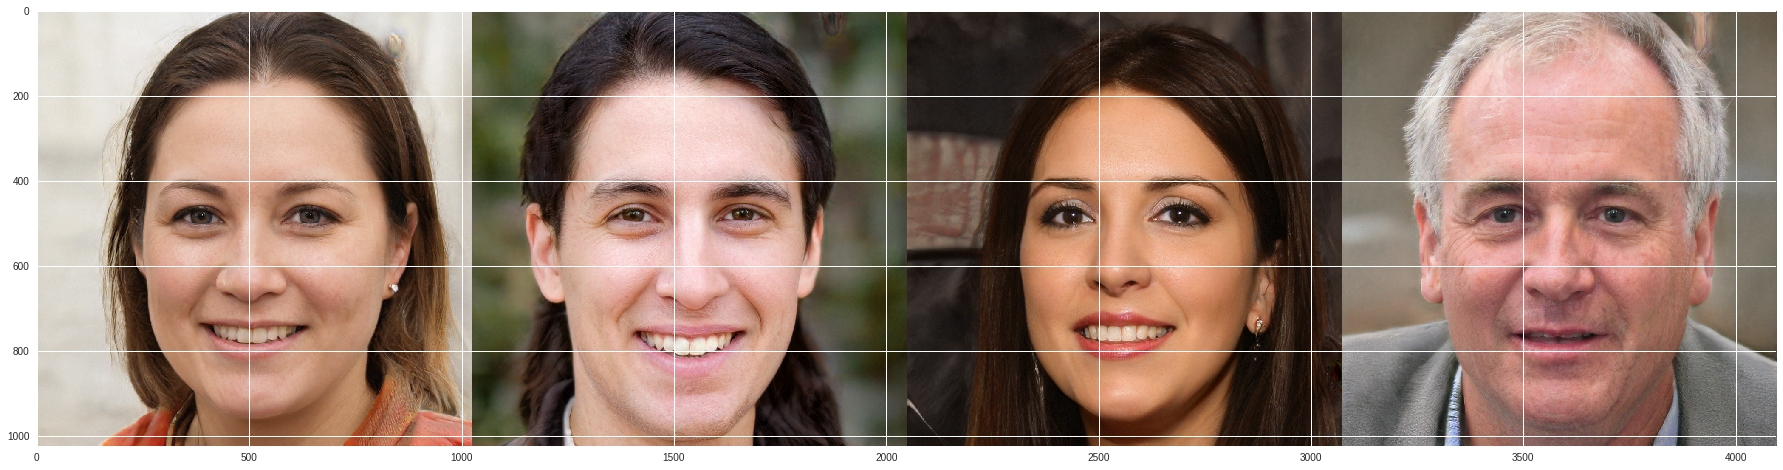

In [14]:
def random_sample(num_images, scale):
    latents = np.random.RandomState(int(1000*random.random())).randn(num_images, *Gs.input_shapes[0][1:])
    labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
    images = Gs.run(latents, None, truncation_psi=truncation, randomize_noise=False, output_transform=fmt)
    images_ct = np.concatenate([img for img in images], axis=1)
    plt.figure(figsize=(scale*num_images, scale))
    plt.imshow(images_ct)
    return images, latents

images, latents = random_sample(4, scale=8)

In [0]:
faves = []
bookmark(latents, [1,3,2])

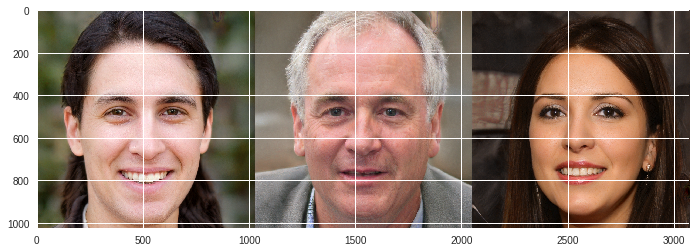

In [16]:
def show_faves(faves):
    latents = np.array(faves)
    labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
    n = len(faves)
    nr, nc = math.ceil(n / 6), 6
    for r in range(nr):
        images = Gs.run(latents[6*r:min(n, 6*(r+1))], None, truncation_psi=truncation, randomize_noise=False, output_transform=fmt)
        img1 = np.concatenate([img for img in images], axis=1)
        plt.figure(figsize=(24,4))
        plt.imshow(img1)

show_faves(faves)

In [17]:
latents = get_latent_interpolation(faves, 5, 'linear', False)
labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])

images = generate_images(latents, labels)    

make_movie(images, '.', 'faves2')


ffmpeg -i frames584265/frame%05d.png -c:v libx264 -pix_fmt yuv420p ./faves2.mp4


In [18]:
def make_movie(images, out_dir, out_name):
    temp_dir = 'frames%06d'%int(1000000*random.random())
    os.system('mkdir %s'%temp_dir)
    for idx in tqdm(range(len(images))):
        images[idx].save('%s/frame%05d.png' % (temp_dir, idx))
    cmd = 'ffmpeg -i %s/frame%%05d.png -c:v libx264 -pix_fmt yuv420p %s/%s.mp4' % (temp_dir, out_dir, out_name)
    print(cmd)
    os.system(cmd)
    os.system('rm -rf %s'%temp_dir)
    

src_latents = get_latent_interpolation(faves_src, 5, 'linear', False)
src_labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])

src_images = generate_images(src_latents, src_labels)    


w = 1024
h = 1024
style_range=range(5,14)

n_src = len(faves_dst)
n_dst = 1

all_images = [] 
for s, src_latent in enumerate(src_latents):

    dst_z = src_latent.reshape((1,512))
    src_z = np.array(faves_dst).reshape((n_src,512))

    src_dlatents = Gs.components.mapping.run(src_z, None) # [seed, layer, component]
    dst_dlatents = Gs.components.mapping.run(dst_z, None) # [seed, layer, component]
    src_images = Gs.components.synthesis.run(src_dlatents, randomize_noise=False, **synthesis_kwargs)
    dst_images = Gs.components.synthesis.run(dst_dlatents, randomize_noise=False, **synthesis_kwargs)

    canvas = PIL.Image.new('RGB', (w * (n_src + 1), h * (n_dst + 1)), 'black')
    for col, src_image in enumerate(list(src_images)):
        canvas.paste(PIL.Image.fromarray(src_image, 'RGB'), ((col + 1) * w, 0))

    for row, dst_image in enumerate(list(dst_images)):
        canvas.paste(PIL.Image.fromarray(dst_image, 'RGB'), (0, (row + 1) * h))
        row_dlatents = np.stack([dst_dlatents[row]] * n_src)
        row_dlatents[:, style_range] = src_dlatents[:, style_range]
        row_images = Gs.components.synthesis.run(row_dlatents, randomize_noise=False, **synthesis_kwargs)
        
        for col, image in enumerate(list(row_images)):
            canvas.paste(PIL.Image.fromarray(image, 'RGB'), ((col + 1) * w, (row + 1) * h))

    all_images.append(canvas)

    
make_movie(all_images, '.', 'faves')

NameError: ignored